In [1]:
# This script uses the GOES-16 or GOES-17 ABI L1b Radiance product to create a georeferenced RGB True-Color image.
# Load the ABI L1b-Rad files of interst from the Amazon Web Service (AWS) S3 Bucket 
# If files of interest have been downloaded, skip cells 3-4 and proceed to cell 5 to open files from a local directory 

# SOURCES:
# Portions of this script have been modified and combined from other tutorials:
# 'GOES-16: True Color Recipe', and 'download_GOES_AWS.py' by Brian Blaylock 
#           at https://unidata.github.io/python-gallery/examples/mapping_GOES16_TrueColor.html
#           and https://gist.github.com/blaylockbk/d60f4fce15a7f0475f975fc57da9104d#file-download_goes_aws-py 
# "Using Python to Explore GOES-16 Data" at http://edc.occ-data.org/goes16/python/

In [2]:
# Import necessary Python modules
from datetime import datetime
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import earthpy.plot as ep
import metpy  
import numpy as np
import s3fs

In [3]:
# Adjust the variables to create the prefix for the file of interest
bucket_name = 'noaa-goes16'
product_name = 'ABI-L1b-RadC'
year = 2020
day_of_year = 157
hour = 16
prefix = f'{bucket_name}/{product_name}/{year}/{day_of_year:03.0f}/{hour:02.0f}/'
print(prefix)

noaa-goes16/ABI-L1b-RadC/2020/157/16/


In [4]:
# Use the anonymous credentials to access public data 
fs = s3fs.S3FileSystem(anon=True)

# List contents of GOES-16 bucket. Adjust to GOES-17 if desired.
fs.ls(bucket_name)

# List specific files of L1 GOES-16 CONUS data of a certain band on a certain hour
files = np.array(fs.ls(prefix))
files = files[:36] # Limit list length to Channels 1 - 3
print(files)

# Download the first file from Channels 1, 2, and 3('C01','C02','C03'). This may take a minute.
# Rename them by the same name (without the directory structure)
fs.get(files[0], files[0].split('/')[-1])
fs.get(files[13], files[13].split('/')[-1])
fs.get(files[25], files[25].split('/')[-1])

['noaa-goes16/ABI-L1b-RadC/2020/157/16/OR_ABI-L1b-RadC-M6C01_G16_s20201571601140_e20201571603513_c20201571603560.nc'
 'noaa-goes16/ABI-L1b-RadC/2020/157/16/OR_ABI-L1b-RadC-M6C01_G16_s20201571606140_e20201571608513_c20201571608563.nc'
 'noaa-goes16/ABI-L1b-RadC/2020/157/16/OR_ABI-L1b-RadC-M6C01_G16_s20201571611140_e20201571613513_c20201571613556.nc'
 'noaa-goes16/ABI-L1b-RadC/2020/157/16/OR_ABI-L1b-RadC-M6C01_G16_s20201571616140_e20201571618513_c20201571618557.nc'
 'noaa-goes16/ABI-L1b-RadC/2020/157/16/OR_ABI-L1b-RadC-M6C01_G16_s20201571621140_e20201571623513_c20201571623569.nc'
 'noaa-goes16/ABI-L1b-RadC/2020/157/16/OR_ABI-L1b-RadC-M6C01_G16_s20201571626140_e20201571628513_c20201571628567.nc'
 'noaa-goes16/ABI-L1b-RadC/2020/157/16/OR_ABI-L1b-RadC-M6C01_G16_s20201571631140_e20201571633513_c20201571633556.nc'
 'noaa-goes16/ABI-L1b-RadC/2020/157/16/OR_ABI-L1b-RadC-M6C01_G16_s20201571636140_e20201571638513_c20201571638557.nc'
 'noaa-goes16/ABI-L1b-RadC/2020/157/16/OR_ABI-L1b-RadC-M6C01_G16

In [5]:
# Navigate to the local paths where the 3 files are stored, and open files. Pathname should end in '.nc'
File1 = ('< Insert Channel 1 pathname >')
File2 = ('< Insert Channel 2 pathname >')
File3 = ('< Insert Channel 3 pathname >')
Band1 = xr.open_dataset(File1)
Band2 = xr.open_dataset(File2)
Band3 = xr.open_dataset(File3)

In [6]:
# Print date and time information

# Scan's start time, converted to datetime object
scan_start = datetime.strptime(Band1.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

# Scan's end time, converted to datetime object
scan_end = datetime.strptime(Band1.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')

# File creation time, convert to datetime object
file_created = datetime.strptime(Band1.date_created, '%Y-%m-%dT%H:%M:%S.%fZ')

# The 't' variable is the scan's midpoint time
midpoint = str(Band1['t'].data)[:-8]
scan_mid = datetime.strptime(midpoint, '%Y-%m-%dT%H:%M:%S.%f')

print('Scan Start    : {}'.format(scan_start))
print('Scan Midpoint : {}'.format(scan_mid))
print('Scan End      : {}'.format(scan_end))
print('File Created  : {}'.format(file_created))
print('Scan Duration : {:.2f} minutes'.format((scan_end-scan_start).seconds/60))

Scan Start    : 2020-06-04 16:01:13.900000
Scan midpoint : 2020-06-04 16:02:32.500000
Scan End      : 2020-06-04 16:03:51.200000
File Created  : 2020-06-04 16:03:55.300000
Scan Duration : 2.62 minutes


In [7]:
# Load the three bands into appropriate red(R), green (G), and blue (B) variables
R = Band2['Rad'].data
G = Band3['Rad'].data
B = Band1['Rad'].data

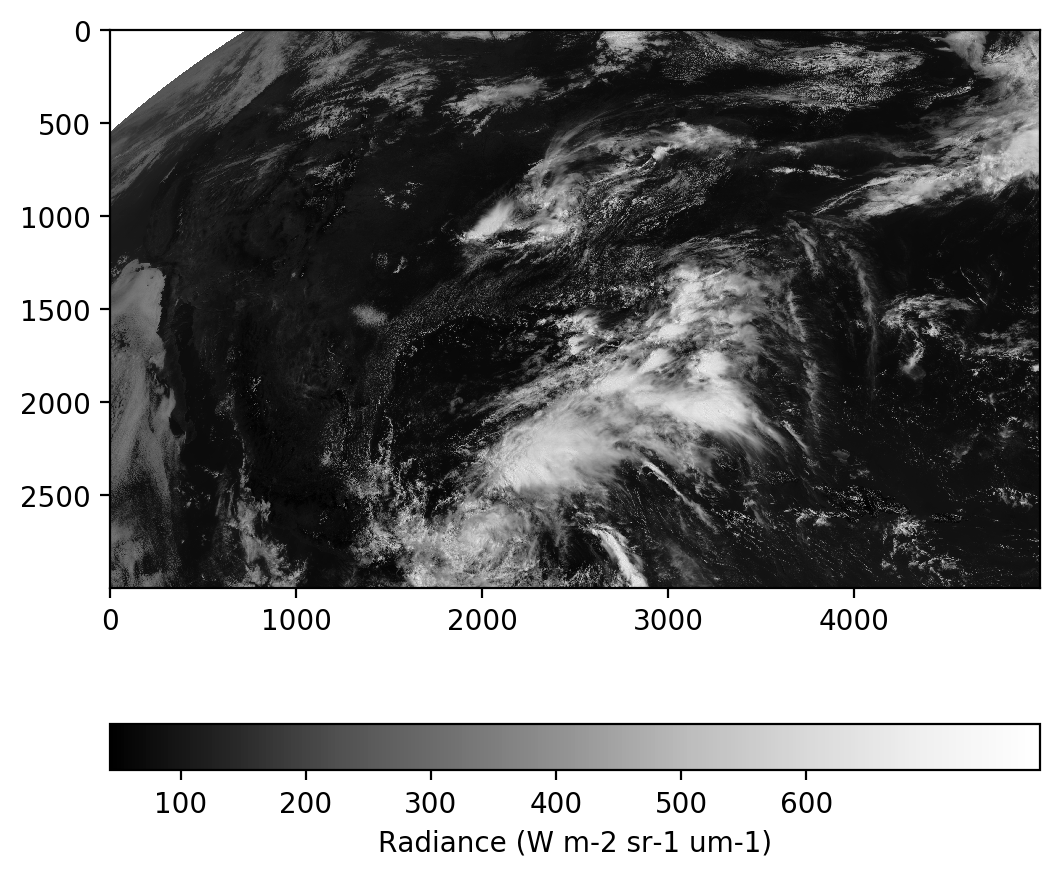

In [8]:
# Plot the Blue Band radiances to check if data loaded correctly
fig = plt.figure(figsize=(6,6),dpi=200)
im = plt.imshow(B, cmap='Greys_r')
cb = fig.colorbar(im, orientation='horizontal')
cb.set_ticks([1, 100, 200, 300, 400, 500, 600])
cb.set_label('Radiance (W m-2 sr-1 um-1)')
plt.show()

In [9]:
# Print the kappa coefficients for each band
kappa_B = Band1['kappa0'].data
kappa_R = Band2['kappa0'].data
kappa_G = Band3['kappa0'].data

print('Band 1 kappa coefficient = ', kappa_B)
print('Band 2 kappa coefficient = ', kappa_R)
print('Band 3 kappa coefficient = ', kappa_G)

Band 1 kappa coefficient =  0.001603199983946979
Band 2 kappa coefficient =  0.001982300076633692
Band 3 kappa coefficient =  0.0033789000008255243


In [10]:
#To convert radiance to reflectance, use formula:
#reflectance (ρf(υ)) = kappa factor(κ) * radiance (L(ν))
#Source: GOES-R Series Product Definition and User Guide (PUG) Volume 3, Revision 2.2, pages 27-28
R_ref = kappa_R * R
G_ref = kappa_G * G  
B_ref = kappa_B * B 

In [11]:
# Apply range limits for each channel. Reflectance values must be between 0 and 1.
R_ref = np.clip(R_ref, 0, 1)
G_ref = np.clip(G_ref, 0, 1)
B_ref = np.clip(B_ref, 0, 1)

In [12]:
# Apply a gamma correction to the image to correct ABI detector brightness
gamma = 2.2
R = np.power(R_ref, 1/gamma)
G = np.power(G_ref, 1/gamma)
B = np.power(B_ref, 1/gamma)

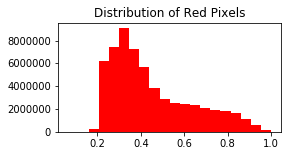

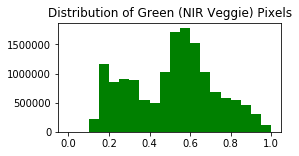

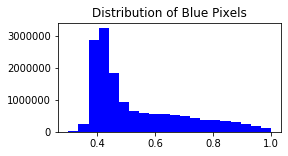

In [13]:
# Create a histogram for each band to display pixel distribution and confirm value range of 0 to 1.
np.warnings.filterwarnings('ignore') # Removes warning that array has NaN pixels  
hist1 = ep.hist(R,
        figsize=(4, 2),
        colors=['red'],
        title=["Distribution of Red Pixels"])

hist2 = ep.hist(G,
        figsize=(4, 2),
        colors=['green'],
        title=["Distribution of Green (NIR Veggie) Pixels"])

hist3 = ep.hist(B,
        figsize=(4, 2),
        colors=['blue'],
        title=["Distribution of Blue Pixels"])

In [14]:
# Define the rebin function that will be used to resample the band resolution
# Rebin function from https://stackoverflow.com/questions/8090229/resize-with-averaging-or-rebin-a-numpy-2d-array
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)


In [15]:
#Resample the Red Band resolution
R_rescaled = rebin(R, [3000, 5000])

In [16]:
# GOES-R Series satellites do not have a channel in the visible green range. Band 3 is a NIR channel typically used to monitor vegetation.
# Calculate the "True" Green Band to serve as a green proxy for the RGB True Color image, using a fractional combination.
# Source: "Generation of GOES‐16 True Color Imagery without a Green Band" - https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018EA000379
G_true = 0.45 * R_rescaled + 0.1 * G + 0.45 * B
G_true = np.clip(G_true, 0, 1)  # Apply band limits again, just in case.

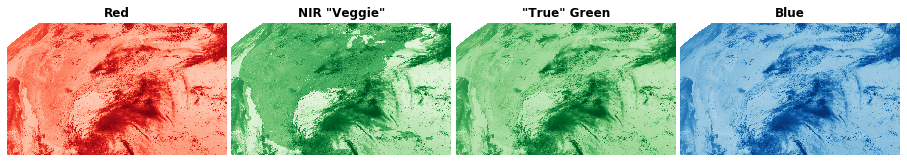

In [17]:
# Plot the four bands: Band 2 (Red), Band 3 (NIR "Veggie"), "True" Green, and Band 1 (Blue)
fig, ([ax1, ax2, ax3, ax4]) = plt.subplots(1, 4, figsize=(16, 3))

ax1.imshow(R_rescaled, cmap='Reds', vmax=1, vmin=0)
ax1.set_title('Red', fontweight='bold')
ax1.axis('off')

ax2.imshow(G, cmap='Greens', vmax=1, vmin=0)
ax2.set_title('NIR "Veggie"', fontweight='bold')
ax2.axis('off')

ax3.imshow(G_true, cmap='Greens', vmax=1, vmin=0)
ax3.set_title('"True" Green', fontweight='bold')
ax3.axis('off')

ax4.imshow(B, cmap='Blues', vmax=1, vmin=0)
ax4.set_title('Blue', fontweight='bold')
ax4.axis('off')

plt.subplots_adjust(wspace=.02)

(-0.5, 4999.5, 2999.5, -0.5)

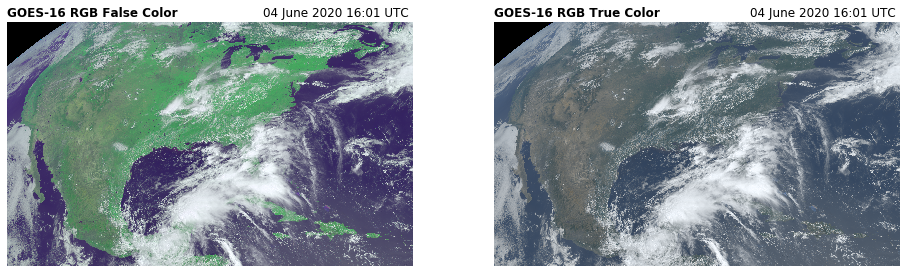

In [18]:
# Combine three RGB channels with a stacked array, then display the resulting images.

# The RGB array with the raw veggie band
RGB_veggie = np.dstack([R_rescaled, G, B])

# The RGB array for the true color image
RGB = np.dstack([R_rescaled, G_true, B])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# False Color: RGB using the NIR "Veggie" Band
ax1.imshow(RGB_veggie)
ax1.set_title('GOES-16 RGB False Color', fontweight='bold', loc='left',
              fontsize=12)
ax1.set_title('{}'.format(scan_start.strftime('%d %B %Y %H:%M UTC ')),
              loc='right')
ax1.axis('off')

# True Color: RGB for the true color image
ax2.imshow(RGB)
ax2.set_title('GOES-16 RGB True Color', fontweight='bold', loc='left',
              fontsize=12)
ax2.set_title('{}'.format(scan_start.strftime('%d %B %Y %H:%M UTC ')),
              loc='right')
ax2.axis('off')

In [19]:
# Plot with `Cartopy` Geostationary Projection

# Use the `CMI_C01` variable as a 'hook' to retrieve the Climate and Forecast (CF) metadata
data = Band1.metpy.parse_cf('Rad')
geostationary = data.metpy.cartopy_crs

# Sweep the ABI data from the x (north/south) and y (east/west) axes
x = data.x
y = data.y

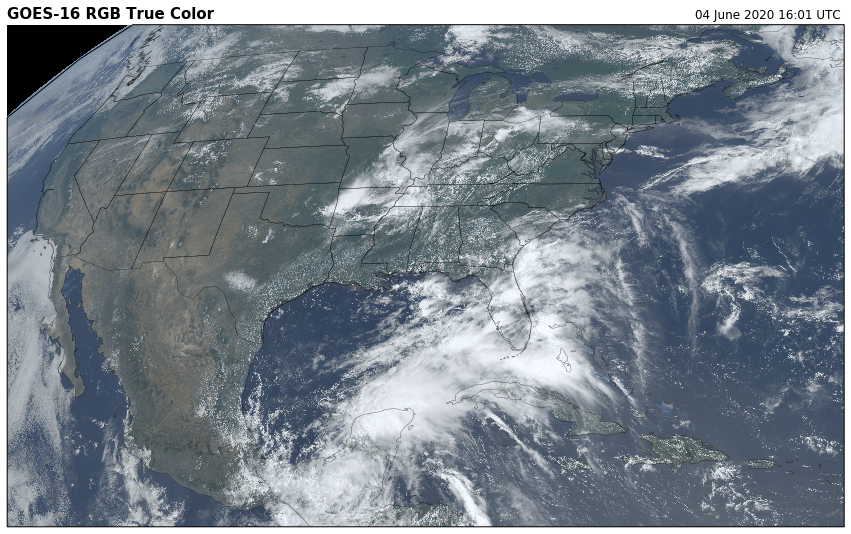

In [20]:
# Use the geostationary projection to plot the image on a map
# This method streches the image across a map with the same projection and dimensions as the data

fig = plt.figure(figsize=(15, 12))

# Create axis with Geostationary projection
ax = fig.add_subplot(1, 1, 1, projection=geostationary)

# Add the RGB True Color image to the figure. The data is in the same projection as the axis created
ax.imshow(RGB, origin='upper',
          extent=(x.min(), x.max(), y.min(), y.max()), transform=geostationary)

# Add coastlines and states
ax.coastlines(resolution='50m', color='black', linewidth=0.25)
ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.25)

#Add title
plt.title('GOES-16 RGB True Color', loc='left', fontweight='bold', fontsize=15)
plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M UTC ')), loc='right')

plt.show()